In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../")


In [2]:
NUM_SAMPLES: int = 100
STATE: int = 2023
IN_FEATURES: int = 2
OUT_FEATURES: int = 1
CLASS_SEP = 1.0
TEMPLATE = "ggplot2"


In [3]:
import torch
from sklearn.datasets import make_classification
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
from tqdm.notebook import tqdm


PALETTE = px.colors.qualitative.Plotly
figKwargs = dict(
    width=700,
    height=400,
)
showKwargs = dict(
    renderer="png", scale=2
)  # change renderer to "" to use interactive plots


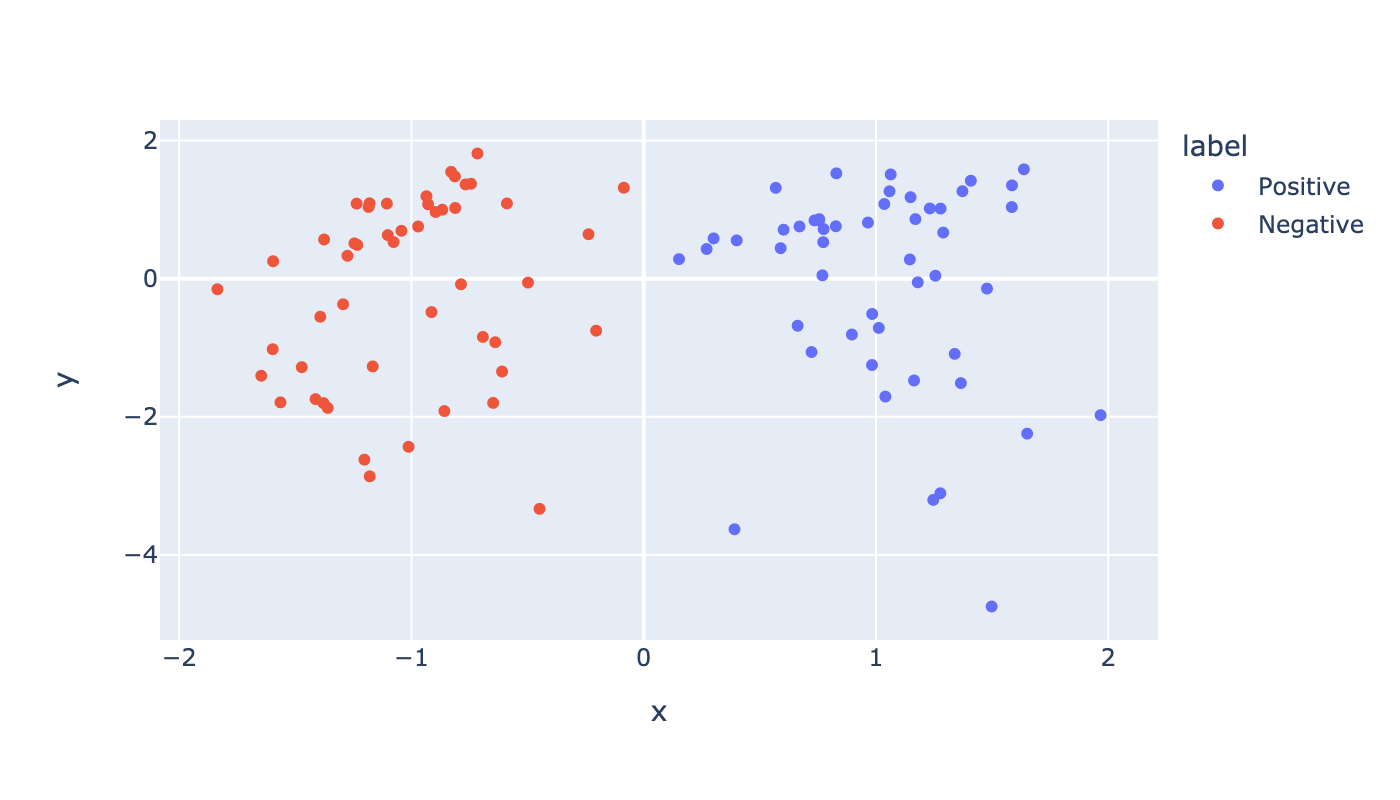

In [4]:
X, y = make_classification(
    n_features=IN_FEATURES,
    n_informative=IN_FEATURES,
    n_clusters_per_class=2,
    n_redundant=0,
    n_classes=2,
    random_state=STATE,
    class_sep=CLASS_SEP,
)
color = ["Positive" if i else "Negative" for i in y]
labels = {"color": "label"}
# X = (X - X.mean(0, keepdims=True)) / X.std(0, keepdims=True)
X = torch.from_numpy(X).to(torch.float32)
y = torch.from_numpy(y).to(torch.float32)
if y.ndim == 1:
    y = y[..., None]
if IN_FEATURES == 2:
    fig = px.scatter(x=X[:, 0], y=X[:, 1], color=color, labels=labels, **figKwargs)
elif IN_FEATURES == 1:
    fig = px.scatter(x=X[:, 0], y=y[:, 0], color=color, labels=labels, **figKwargs)
else:
    raise ValueError
fig.show(**showKwargs)


In [43]:
from ml.losses.classification import BCELoss
from ml.activations.functional import sigmoid
from ml.models.linear import Linear, LogisticRegression
from ml.optim import SGD

LR = 0.1
REG = 0.01
N = 1000

activation = sigmoid
criterion = BCELoss()
model = LogisticRegression(IN_FEATURES, OUT_FEATURES)
optim = SGD(model.parameters(), model.grad(), LR, weight_decay=REG)

# PyTorch init
t_model = torch.nn.Linear(IN_FEATURES, OUT_FEATURES)
# Start with same parameters
t_model.weight = torch.nn.Parameter(model.weight.clone())
t_model.bias = torch.nn.Parameter(model.bias.clone())
t_criterion = torch.nn.BCEWithLogitsLoss()


In [44]:
model.fit(X, y, criterion, optim, n_epochs=N, verbose=True)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [45]:
history = []
for _ in tqdm(range(N)):
    for p in t_model.parameters():
        p.grad = None
    output = t_model(X)
    loss = t_criterion(output, y)
    loss.backward()
    for p in t_model.parameters():
        reg = 2 * p.data.sum() * REG
        p.data -= (p.grad + reg) * LR
    history.append(loss.item())


  0%|          | 0/1000 [00:00<?, ?it/s]

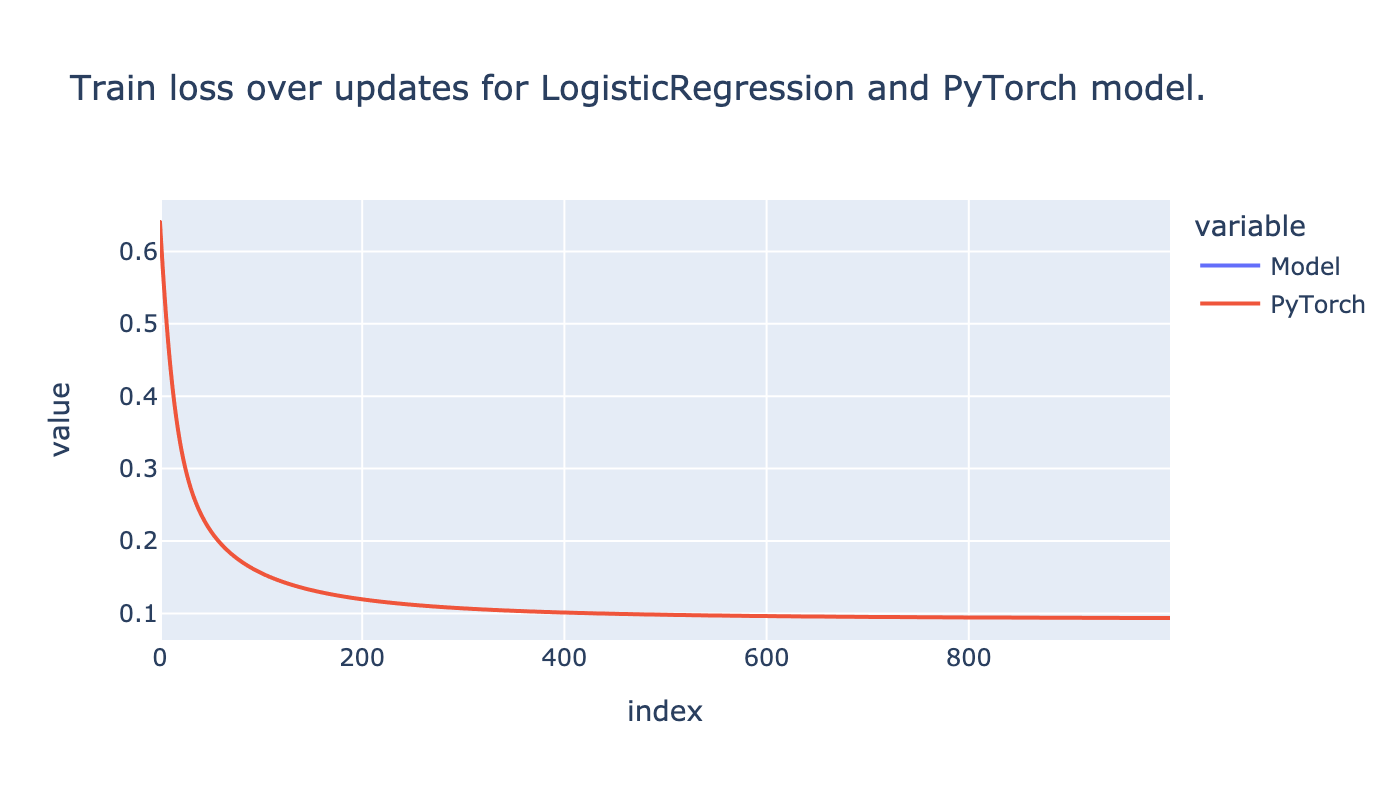

In [46]:
data = pd.DataFrame(dict(Model=model.history, PyTorch=history))
fig = px.line(
    data,
    title="Train loss over updates for LogisticRegression and PyTorch model.",
    ** figKwargs,
)
fig.show(**showKwargs)


In [47]:
# check that weights and biases are close

assert torch.allclose(t_model.weight.data, model.weight.data)
assert torch.allclose(t_model.bias.data, model.bias.data)


In [48]:
t_model.weight.data, model.weight

(tensor([[ 3.0421, -0.4428]]), tensor([[ 3.0421, -0.4428]]))

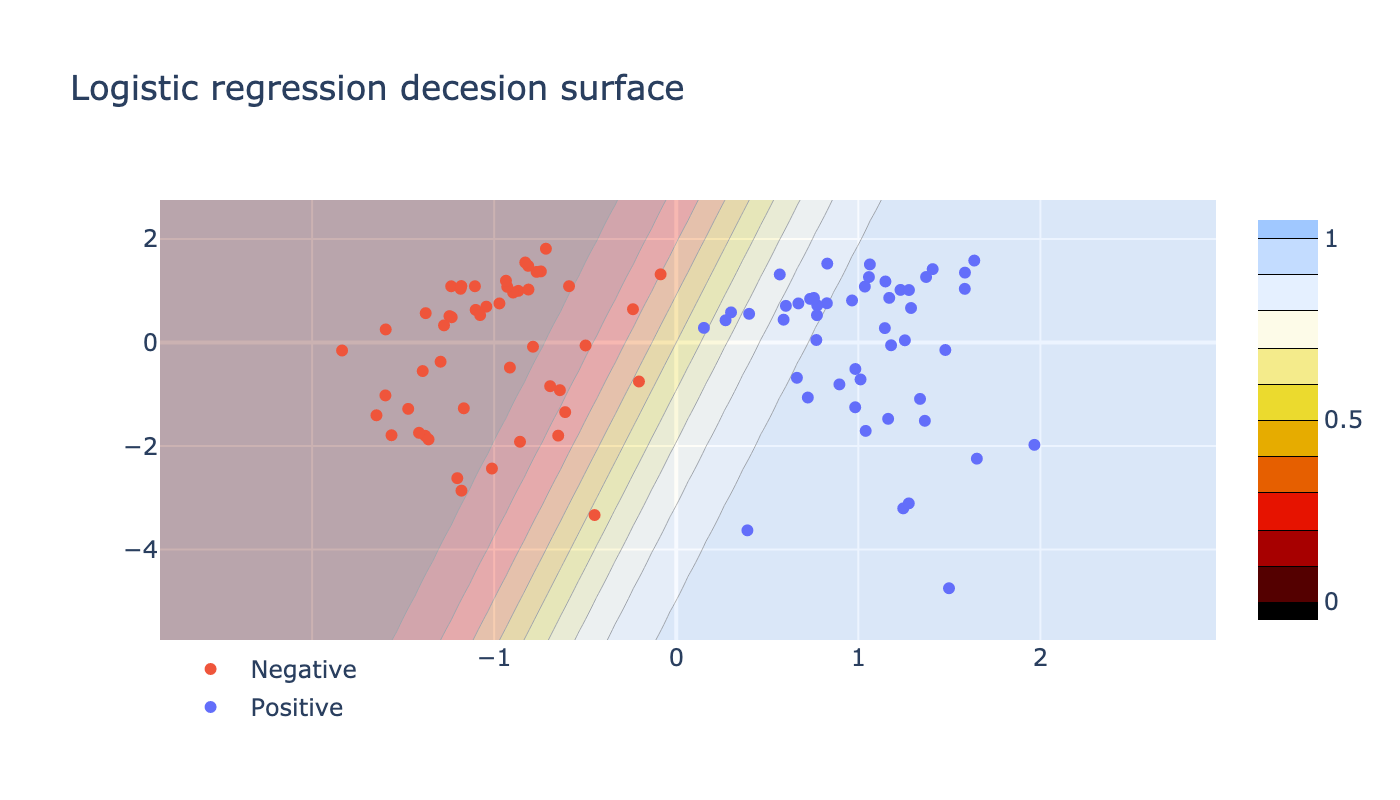

In [49]:
h = 0.1
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = torch.meshgrid(
    torch.arange(x_min, x_max, h), torch.arange(y_min, y_max, h), indexing="ij"
)
levels = torch.linspace(0, 1, 1000)
grid = torch.dstack([xx.ravel(), yy.ravel()])[0]
gridOut = model.predict(grid)

fig = go.Figure(
    data=go.Contour(
        x=xx[:, 0],
        y=yy[0],
        z=gridOut.reshape(xx.shape).T,
        opacity=0.3,
        line_smoothing=1.0,
        colorscale="Blackbody",
    )
)
x1 = X[y.squeeze() == 0.0]
x2 = X[y.squeeze() == 1.0]
fig.add_trace(
    go.Scatter(
        x=x1[:, 0], y=x1[:, 1], mode="markers", name="Negative", line_color=PALETTE[1]
    )
)
fig.add_trace(
    go.Scatter(
        x=x2[:, 0], y=x2[:, 1], mode="markers", name="Positive", line_color=PALETTE[0]
    )
)
fig.update_layout(
    title="Logistic regression decesion surface",
    legend=dict(yanchor="top", y=0.00, xanchor="left", x=0.01),
    **figKwargs
)
fig.show(**showKwargs)


In [51]:
from ml.metrics.functional import get_stats, accuracy

thr = 0.5
b_output = (model.predict(X) > thr).to(torch.long)
b_target = y.to(torch.long)
stats = get_stats(b_output, b_target)
accuracy(*stats, average="micro")

tensor(0.9900)